In [1]:
from math import floor
import numpy as np

def row_col_to_seq(row_col, num_cols):  #Converts state number to row_column format
    return row_col[:,0] * num_cols + row_col[:,1]

def seq_to_col_row(seq, num_cols): #Converts row_column format to state number
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1 # default is no discounting
        self.wind = wind

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq)

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]

            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          return next_next, self.R[next_next]
        else:
          return next_state, self.R[next_state]


In [2]:
# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[3,6]])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                              bias=0.5)
env = gw.create_gridworld()

In [3]:
print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

Number of actions 4
Number of states 100
start state [36]
goal state(s) [ 9 22 87]


In [4]:
for i in range(10):
    print(env.P[0,10*i:10*i+10,3])

[0.15 0.7  0.   0.   0.   0.   0.   0.   0.   0.  ]
[0.15 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# Tasks

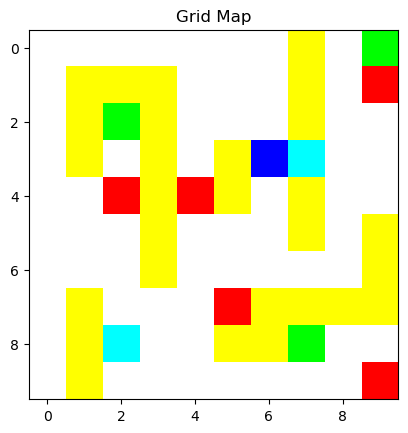

In [5]:
from scipy.special import softmax
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm import tqdm

Environment = np.ones([env.num_rows,num_cols,3])
for it in env.start_state:
    Environment[it[0]][it[1]] = [0,0,1]
for it in env.goal_states:
    Environment[it[0]][it[1]] = [0,1,0]
for it in env.obs_states:
    Environment[it[0]][it[1]] = [1,1,0]
for it in env.bad_states:
    Environment[it[0]][it[1]] = [1,0,0]
for it in env.restart_states:
    Environment[it[0]][it[1]] = [0,1,1]
plt.imshow(Environment)
plt.title("Grid Map");

In [6]:
from scipy.special import softmax
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm import tqdm
from re import A
import numpy as np

class Policy():
    def __init__(self,env,policy_algo='sarsa',algo='softmax',alpha0 = 0.4, gamma = 0.9, episodes = 5000, epsilon0 = 0.1,plot_heat=False,rg=np.random.RandomState(42)):
        self.env = env
        self.policy_algo = policy_algo
        self.algo = algo
        self.Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
        self.V = np.zeros((env.num_rows, env.num_cols))
        self.alpha0 = alpha0
        self.gamma = gamma
        self.episodes = episodes
        self.epsilon = epsilon0
        self.rg = rg
        self.plot_heat = plot_heat
        self.print_freq = 100
        self.episode_rewards = np.zeros(self.episodes)
        self.steps_to_completion = np.zeros(self.episodes)
        
        
    def choose_action_epsilon(self, state):
        if not self.Q[state[0], state[1]].any():
            return self.rg.choice([0,1,2,3]) 
        else:
            prob = np.array([self.epsilon/4,self.epsilon/4,self.epsilon/4,self.epsilon/4])
            prob[np.argmax(self.Q[state[0], state[1]])]+=(1-self.epsilon)
            return self.rg.choice([0,1,2,3],p=prob) 
        
    def choose_action_softmax(self, state):
        Q_softmax = softmax(self.Q[state[0],state[1]]/(10*self.epsilon))
        return self.rg.choice([0,1,2,3],p=Q_softmax) 
    
    def plot_Q(self,message = "Q plot"):
        DOWN = 1
        UP = 0
        LEFT = 2
        RIGHT = 3

        plt.title(message)
        plt.pcolor(self.Q.max(-1), edgecolors='k', linewidths=2) #,cmap="rainbow"
        plt.colorbar()
        def x_direct(a):
            if a in [UP, DOWN]:
                return 0
            return 1 if a == RIGHT else -1
        def y_direct(a):
            if a in [RIGHT, LEFT]:
                return 0
            return 1 if a == UP else -1
        policy = self.Q.argmax(-1)
        policyx = np.vectorize(x_direct)(policy)
        policyy = np.vectorize(y_direct)(policy)
        idx = np.indices(policy.shape)
        plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
        ax = plt.gca()
        ax.invert_yaxis()
        
    def train_policy(self):
        if(self.algo.lower()=='epsilon'):
            choose_action = self.choose_action_epsilon
        elif(self.algo.lower()=='softmax'):
            choose_action = self.choose_action_softmax
        else:
            raise Exception("Choose among 'epsilon' or 'softmax'")
        
        if self.plot_heat:
            plt.figure(figsize=(10,10))
            clear_output(wait=True)
            self.plot_Q()
            plt.show()
        for ep in tqdm(range(self.episodes)):
            tot_reward, steps = 0, 0
            # Reset environment
            state = self.env.reset()
            state_row_col = seq_to_col_row(state, self.env.num_cols)
            self.V[state_row_col[0][0],state_row_col[0][1]]+=1
            #print(state,state_row_col)
            action = choose_action(state_row_col[0])
            #print(action)
            done = False
            count = 0
            while not done:
                state_next, reward = self.env.step(state,action)
                state_next_row_col = seq_to_col_row(state_next, self.env.num_cols)
                action_next = choose_action(state_next_row_col[0])
                if(state_next in self.env.goal_states_seq or count==99):
                    done = True
                if(self.policy_algo == 'sarsa'):
                    self.Q[state_row_col[0][0],state_row_col[0][1],action]+=self.alpha0*(reward+self.gamma*self.Q[state_next_row_col[0][0],state_next_row_col[0][1],action_next]-self.Q[state_row_col[0][0],state_row_col[0][1],action])
                elif(self.policy_algo == 'qlearning'):
                    self.Q[state_row_col[0][0],state_row_col[0][1],action]+=self.alpha0*(reward+self.gamma*max(self.Q[state_next_row_col[0][0],state_next_row_col[0][1],:])-self.Q[state_row_col[0][0],state_row_col[0][1],action])
                else:
                    raise Exception("Choose Policy Algorithm among 'sarsa' or 'qlearning'")
                tot_reward += reward
                steps += 1
                state, state_row_col,action = state_next,state_next_row_col ,action_next
                self.V[state_row_col[0][0],state_row_col[0][1]]+=1
                count+=1

            self.episode_rewards[ep] = tot_reward
            self.steps_to_completion[ep] = steps

            if (ep+1)%self.print_freq == 0 and self.plot_heat:
                clear_output(wait=True)
                plt.figure(figsize=(10,10))
                self.plot_Q(message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(self.episode_rewards[ep-self.print_freq+1:ep]),
                                                                               np.mean(self.steps_to_completion[ep-self.print_freq+1:ep]),
                                                                               self.Q.max(), self.Q.min()))
                plt.show()

        return self.Q, self.V, self.episode_rewards, self.steps_to_completion


In [7]:
def plot_Q(Q,message = "Q plot"):
        DOWN = 1
        UP = 0
        LEFT = 2
        RIGHT = 3

        plt.title(message,fontsize=18)
        plt.pcolor(Q.max(-1), edgecolors='k', linewidths=2) #,cmap="rainbow"
        plt.colorbar()
        def x_direct(a):
            if a in [UP, DOWN]:
                return 0
            return 1 if a == RIGHT else -1
        def y_direct(a):
            if a in [RIGHT, LEFT]:
                return 0
            return 1 if a == UP else -1
        policy = Q.argmax(-1)
        policyx = np.vectorize(x_direct)(policy)
        policyy = np.vectorize(y_direct)(policy)
        idx = np.indices(policy.shape)
        plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        ax = plt.gca()
        ax.invert_yaxis()
def plot4plots(Q, V , rewards , steps, text=False):
        plt.figure(figsize=[24,20])
        plt.subplot(221)
        plt.plot(np.arange(len(rewards)),rewards)
        plt.xlabel('Episode',fontsize=18)
        plt.ylabel('Total Reward',fontsize=18)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.title("Total Reward vs Episode",fontsize=18)
        plt.subplot(222)
        plt.plot(np.arange(len(steps)),steps)
        plt.xlabel('Episode',fontsize=18)
        plt.ylabel('Number of steps to Goal',fontsize=18)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.title("Steps to Goal vs Episode",fontsize=18)
        plt.subplot(223)
        c = plt.pcolor(V)
        if(text):
            show_values(c)
        ax = plt.gca()
        ax.invert_yaxis()
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.colorbar()
        plt.title("State Visit Count Heatmap",fontsize=18)
        #plt.colorbar()
        plt.subplot(224)
        plot_Q(Q)
def show_values(pc, fmt="%.2f", **kw):
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)

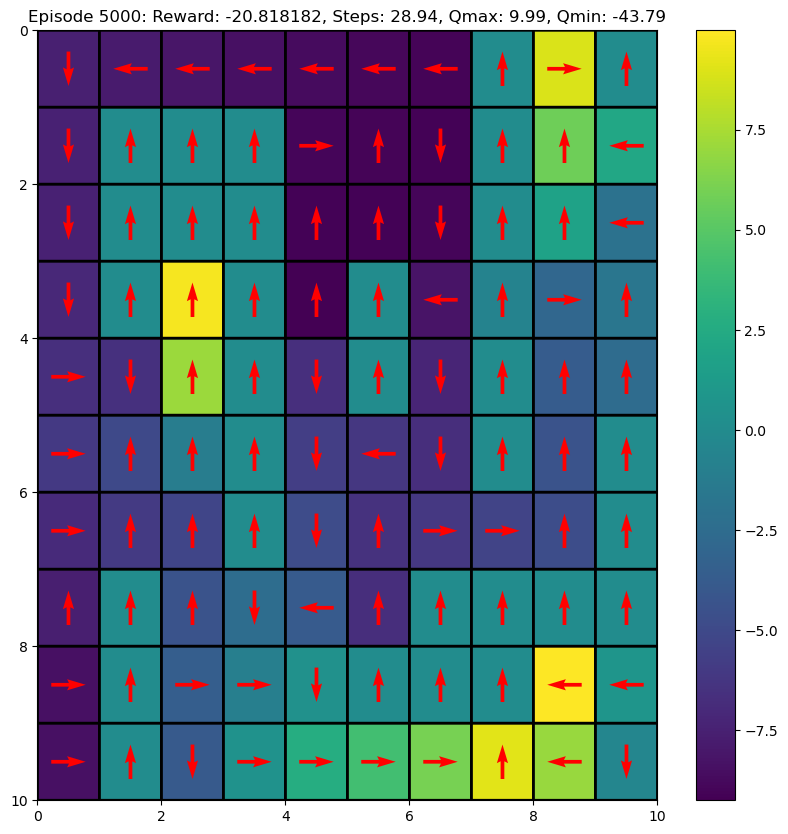

100%|██████████| 5000/5000 [00:32<00:00, 152.20it/s]


In [8]:
rg = np.random.RandomState(0)
policy = Policy(env,'qlearning','softmax',epsilon0=0.01,plot_heat=True,rg=rg)
Q, V, rewards, steps = policy.train_policy()

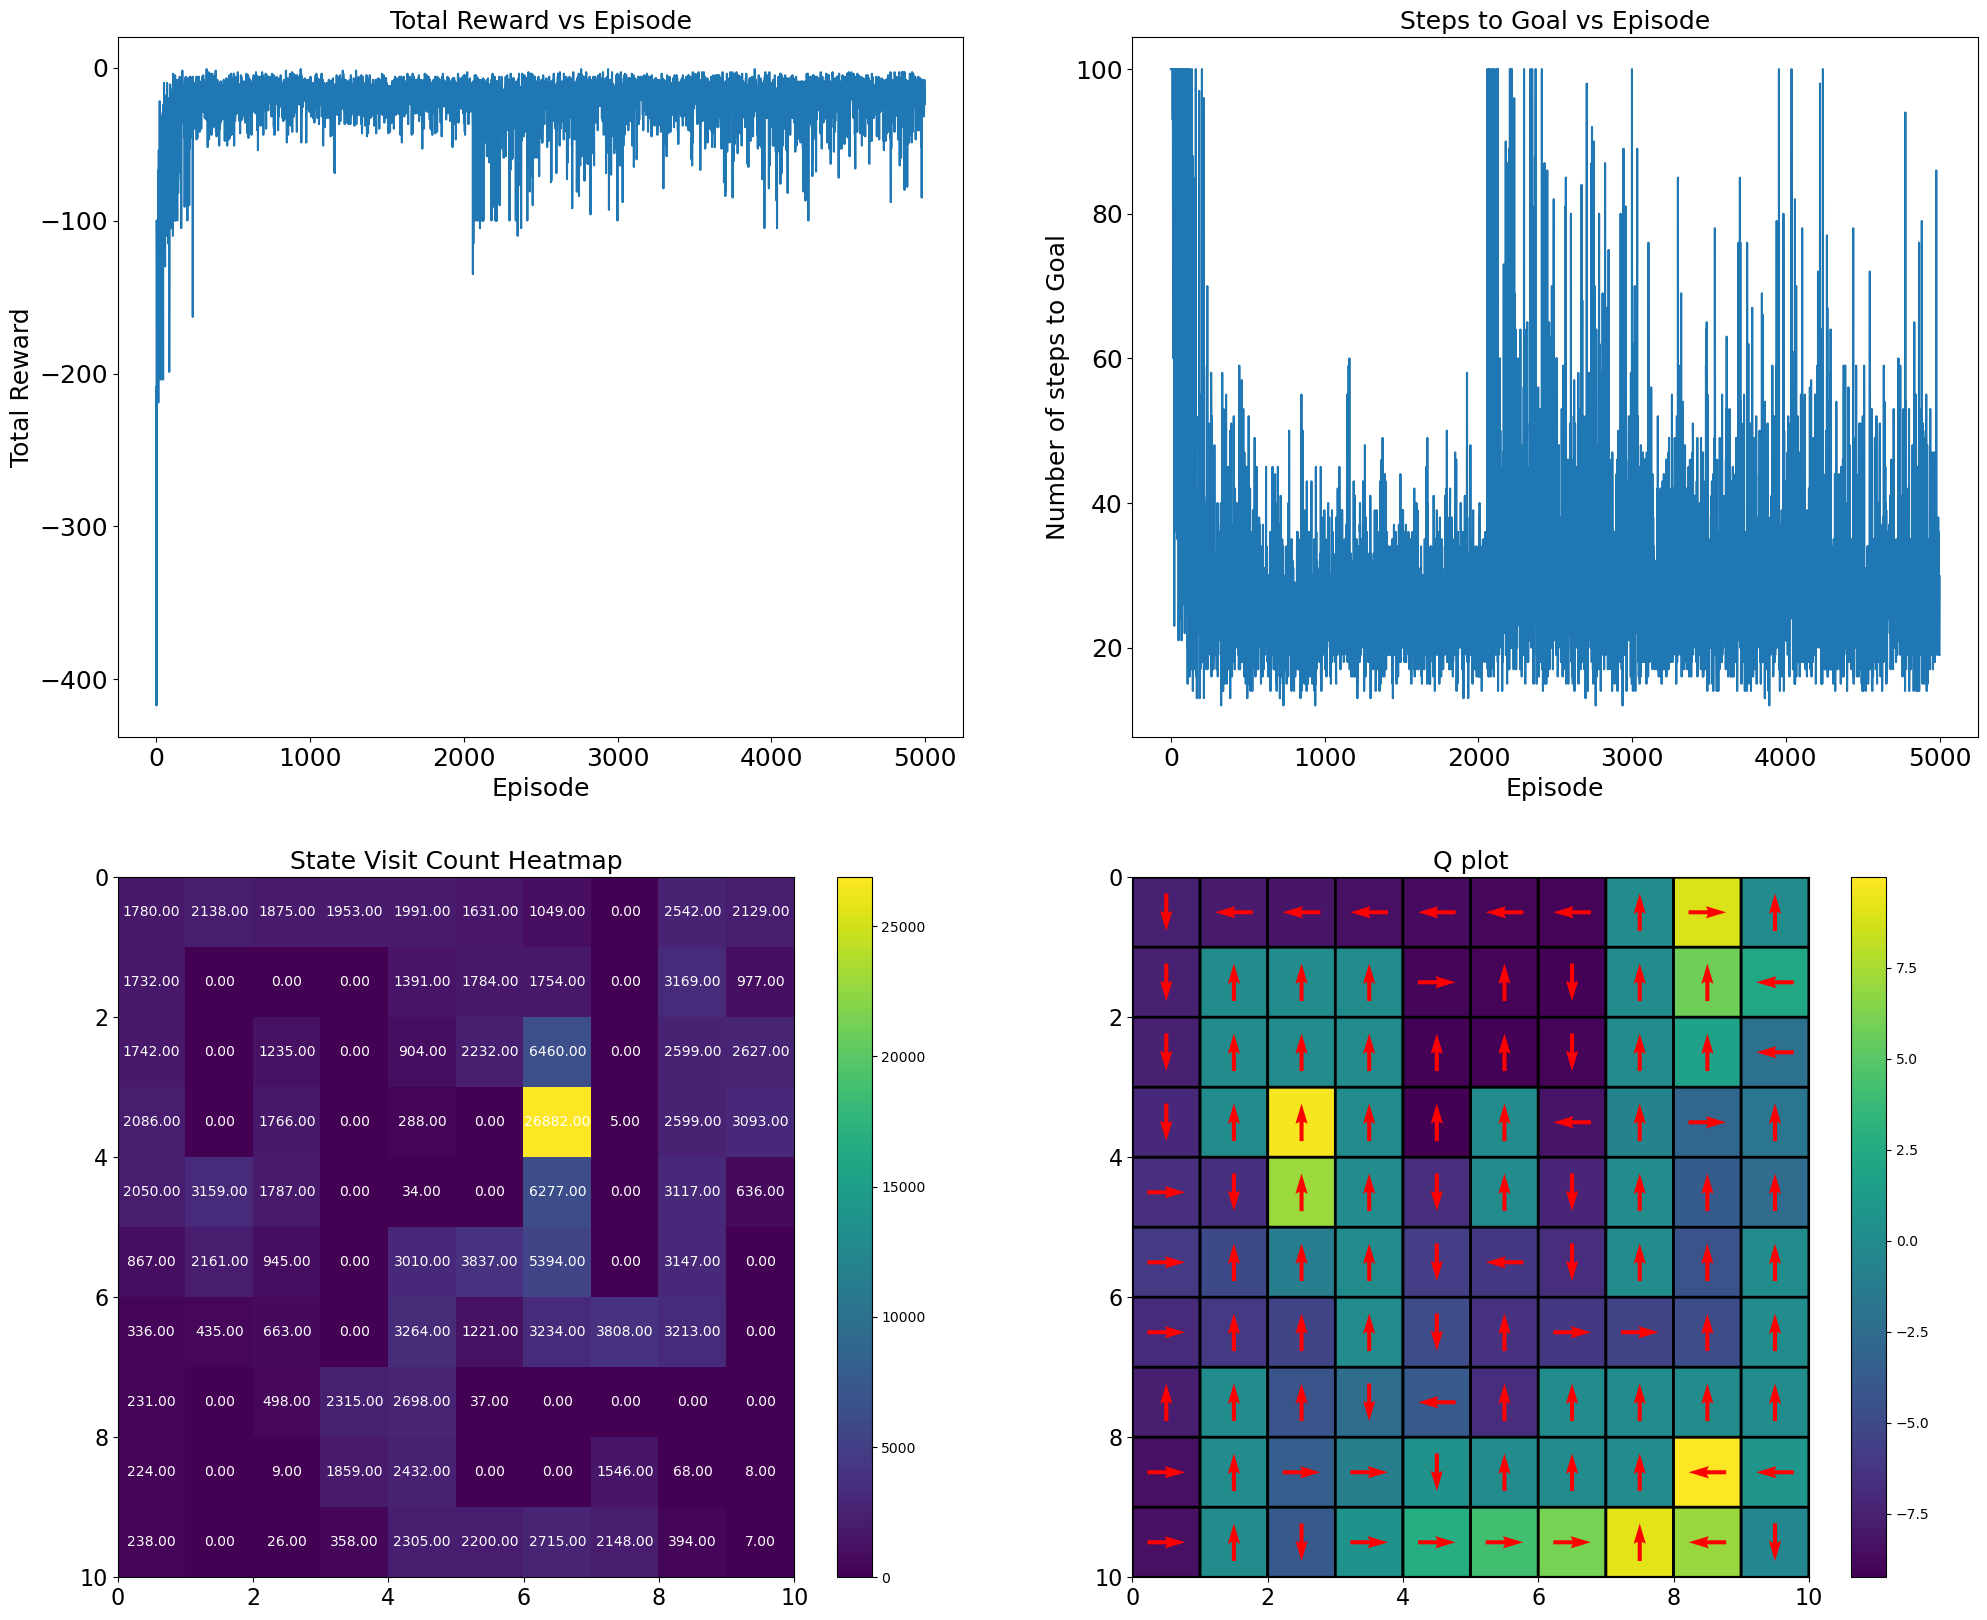

In [9]:
plot4plots(Q, V, rewards, steps,text=True)

In [10]:
def do_experiments(Policy_algo = 'sarsa', algo='softmax',alpha0 = 0.4, gamma = 0.9, episodes = 5000, epsilon0 = 0.1,num_expts=5):
    Policy_algo = Policy_algo.lower()
    algo=algo.lower()
    policy = Policy(env=env,episodes = episodes)
    reward_avgs, steps_avgs = np.zeros(policy.episodes), np.zeros(policy.episodes)
    Q_mean = np.zeros((policy.env.num_rows, policy.env.num_cols, policy.env.num_actions))
    V_mean = np.zeros((policy.env.num_rows, policy.env.num_cols))
    for i in range(num_expts):
        print("Experiment: %d"%(i+1))
        rg = np.random.RandomState(i)
        policy = Policy(env=env,policy_algo=Policy_algo,algo=algo,alpha0 = alpha0, gamma = gamma, episodes = episodes, epsilon0 = epsilon0,rg=rg)
        Q, V, rewards, steps = policy.train_policy()
        reward_avgs+=rewards
        steps_avgs+=steps
        Q_mean+=Q
        V_mean+=V
    return Q_mean/num_expts, V_mean/num_expts, reward_avgs/num_expts, steps_avgs/num_expts
def test_policy(env,Q,num_expts):
    total_steps = np.zeros(num_expts)
    total_rewards = np.zeros(num_expts)
    for i in range(num_expts):
        state = env.reset()
        state_row_col = seq_to_col_row(state, env.num_cols)
        done = False
        steps = 0
        tot_reward = 0
        count = 0
        while not done:
            clear_output(wait=True)
            state, reward = env.step(state,Q[state_row_col[0][0], state_row_col[0][1]].argmax())
            state_row_col = seq_to_col_row(state, env.num_cols)
            if(state in env.goal_states_seq or count==99):
                done = True
            steps += 1
            tot_reward += reward
            count+=1
        total_steps[i] = steps
        total_rewards[i] = tot_reward
    return np.mean(total_steps), np.mean(total_rewards)

In [11]:
#Q, V, rewards, steps = do_experiments(Policy_algo='Sarsa',algo='softmax',alpha0 = 0.4, gamma = 0.9, episodes = 5000, epsilon0 = 0.1,num_expts=5)

In [12]:
#plot4plots(Q, V, rewards, steps,text=True)

In [13]:
'''s,r = test_policy(env,Q,num_expts=5)
s,r'''

's,r = test_policy(env,Q,num_expts=5)\ns,r'

# For Better Understanding

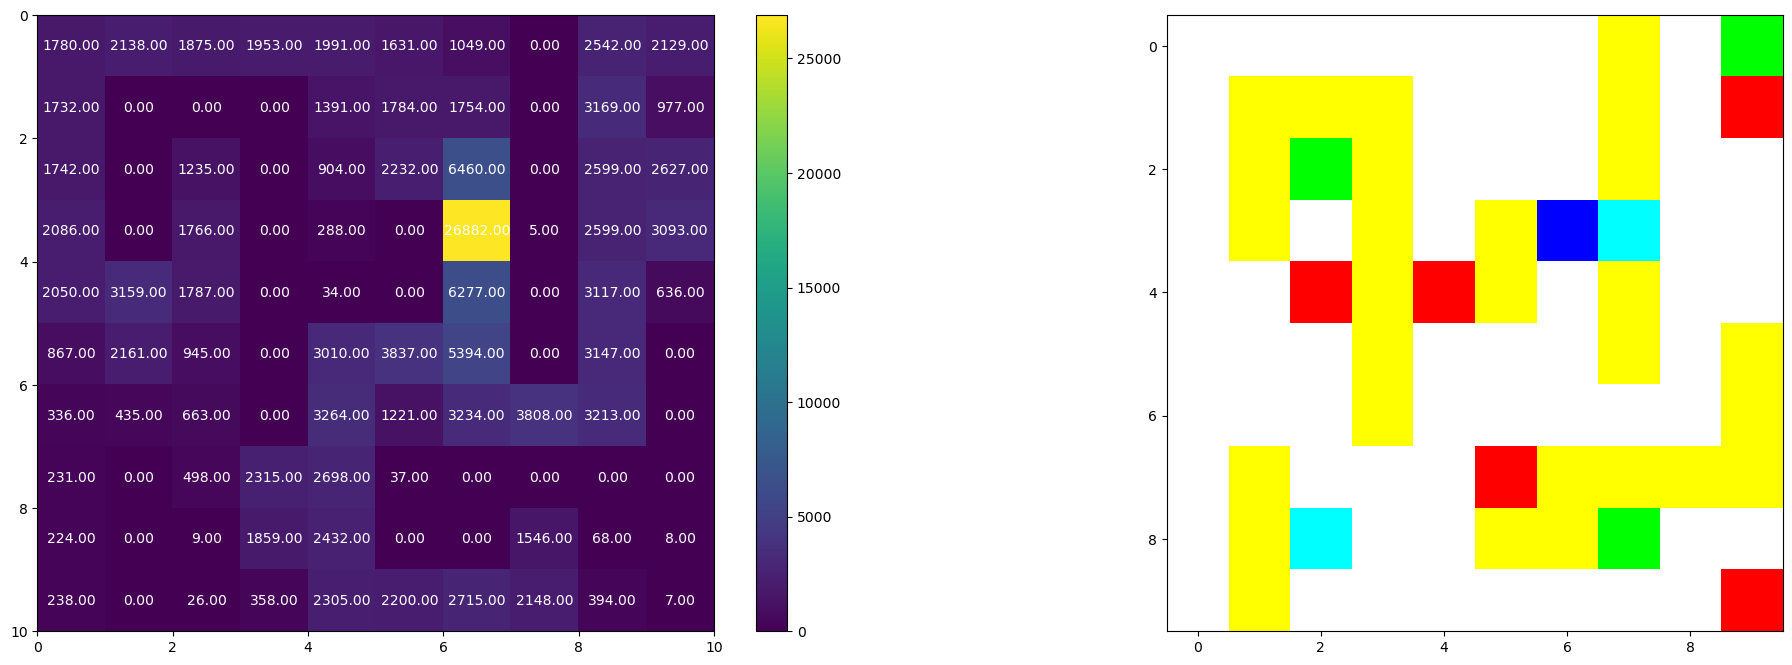

In [14]:
plt.figure(figsize=[24,8])
plt.subplot(121)
c = plt.pcolor(V)
ax = plt.gca()
ax.invert_yaxis()
show_values(c)
plt.colorbar()
plt.subplot(122)
plt.imshow(Environment)
plt.show()

# Hyperparameter Tuning

In [15]:
import wandb
wandb.login(key="8545e71f98dc96fbac53295facb12404fc77016d")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nayinisriharsh-iitm. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\nayin/.netrc


True

In [17]:
def train_and_tune(config=None):
  # Initialize a new wandb run
  with wandb.init(config=config):
    # If called by wandb.agent, as below,
    # this config will be set by Sweep Controller
    config = wandb.config
    wandb.run.name='pa_'+str(config.policy_algorithm)+'-al_'+str(config.algorithm)+'-alpha_'+str(config.alpha)+'-gam_'+str(config.gamma)+'-epitau_'+str(config.epsilon_tau)+'-episo_'    
    Q, V, rewards, steps = do_experiments(Policy_algo=config.policy_algorithm,algo=config.algorithm,alpha0 = config.alpha, gamma = config.gamma, episodes = config.episodes, epsilon0 = config.epsilon_tau,num_expts=config.number_of_experiments)
    s,r = test_policy(env,Q,num_expts=5)
    #wandb.log({"train_mean_reward":rewards,"train_mean_steps":steps,"test_mean_reward":r,"train_mean_steps":s})
    #data = [[x, y] for (x, y) in zip(np.arange(config.episodes), rewards)]
    #table1 = wandb.Table(data=data, columns=["x", "y"])
    #data = [[x, y] for (x, y) in zip(np.arange(config.episodes), steps)]
    #table2 = wandb.Table(data=data, columns=["x", "y"])
    wandb.log(
        {
            "avg_test_reward":r,'avg_test_steps':s #,"train_reward": wandb.plot.line(table1, "x", "y", title="Reward vs Episode"),"train_steps": wandb.plot.line(table2, "x", "y", title="Steps vs Episode"),
        }
    )

In [18]:
sweep_config={'method':'bayes',
              'metric' : {
                  'name':'avg_test_reward',
                  'goal':'maximize'},
              'parameters':{ 
                  'policy_algorithm':{'values':['qlearning']} ,
                  'algorithm':{'values':['softmax','epsilon']},
                  'alpha':{'values':[0.6,0.5,0.4,0.3]},
                  'gamma':{'values':[1,0.9,0.8,0.7,0.5]},
                  'episodes':{'values':[5000]},
                  'epsilon_tau':{'values':[0.001,0.01,0.05,0.1,0.2,0.3]},
                  'number_of_experiments':{'values':[5]} }}
import pprint
pprint.pprint(sweep_config)
sweep_id=wandb.sweep(sweep_config,project="CS6700_PROGRAMMING_ASSIGNMENT_1")

{'method': 'bayes',
 'metric': {'goal': 'maximize', 'name': 'avg_test_reward'},
 'parameters': {'algorithm': {'values': ['softmax', 'epsilon']},
                'alpha': {'values': [0.6, 0.5, 0.4, 0.3]},
                'episodes': {'values': [5000]},
                'epsilon_tau': {'values': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3]},
                'gamma': {'values': [1, 0.9, 0.8, 0.7, 0.5]},
                'number_of_experiments': {'values': [5]},
                'policy_algorithm': {'values': ['qlearning']}}}
Create sweep with ID: ayvltohl
Sweep URL: https://wandb.ai/nayinisriharsh-iitm/CS6700_PROGRAMMING_ASSIGNMENT_1/sweeps/ayvltohl


In [19]:
'''
{'method': 'bayes',
 'metric': {'goal': 'maximize', 'name': 'avg_test_reward'},
 'parameters': {'algorithm': {'values': ['softmax', 'epsilon']},
                'alpha': {'values': [0.6, 0.5, 0.4, 0.3]},
                'episodes': {'values': [5000]},
                'epsilon_tau': {'values': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3]},
                'gamma': {'values': [1, 0.9, 0.8, 0.7, 0.5]},
                'number_of_experiments': {'values': [5]},
                'policy_algorithm': {'values': ['qlearning']}}}
Create sweep with ID: ayvltohl
Sweep URL: https://wandb.ai/nayinisriharsh-iitm/CS6700_PROGRAMMING_ASSIGNMENT_1/sweeps/ayvltohl
'''

"\n{'method': 'bayes',\n 'metric': {'goal': 'maximize', 'name': 'avg_test_reward'},\n 'parameters': {'algorithm': {'values': ['softmax', 'epsilon']},\n                'alpha': {'values': [0.6, 0.5, 0.4, 0.3]},\n                'episodes': {'values': [5000]},\n                'epsilon_tau': {'values': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3]},\n                'gamma': {'values': [1, 0.9, 0.8, 0.7, 0.5]},\n                'number_of_experiments': {'values': [5]},\n                'policy_algorithm': {'values': ['qlearning']}}}\nCreate sweep with ID: ayvltohl\nSweep URL: https://wandb.ai/nayinisriharsh-iitm/CS6700_PROGRAMMING_ASSIGNMENT_1/sweeps/ayvltohl\n"

In [20]:
wandb.agent(sweep_id, train_and_tune,count=50)

avg_test_reward,▁
avg_test_steps,▁
avg_test_reward,-16.8
avg_test_steps,22.8
